In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Set the width to fit all columns
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
data = pd.concat([train, test]) 
dfs = [train,test]
display(data.head(5))
print(data.shape, train.shape, test.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(1309, 12) (891, 12) (418, 11)


## Data Clean-up:
We have two major issues to contend with to get our data ready for our simple modeling approach: 
#### 1. Some Features Are Categorical: this means they contain non-numeric data types, which our models cannot handle natively
These features are:
* `Name`
* `Sex`
* `Ticket`
* `Cabin`
* `Embarked`

#### 2. Some Samples Contain `NaN` Values: this means some records are missing information

### Numeric Feature Cleaning Using Statistical Descriptors:

In [9]:
# ---- STATS ---- # 
# data.describe() 
# avgs: 38.4% survival, pclass 2.3, age 29.9, sibsp .5, parch .4, fare 33.3
# fairly high std devs
# less than 25% pclass == 1, over 50% == 2

# ---- Missing and Filling ---- #
data.isna().sum() # Age is missing 263 values, fare is missing 1.
corr = data.corr()
corr[corr.index == "Age"] # Result: class and age have a very strong relationship.

# Intuition: Gender may also impact age within the classes.
grouped_medians = data.groupby(['Pclass', 'Sex'])['Age'].median() # Calculates and displays groups

# Creates series of shape = data['Age'] with the median age for each group at the same idx as a person of that group
grouped_medians = data.groupby(['Pclass', 'Sex'])['Age'].transform('median') 
data['Age'].fillna(grouped_medians, inplace=True)

# Single missing fare: Pclass 3, male, alone, embarked at southampton
na_fare_idx = data[data['Fare'].isna()]['Fare'].index
data.loc[na_fare_idx,"Fare"] = data[(data["Embarked"] == "S") & (data["Sex"]=="male") & (data["Pclass"] == 3) & (data["SibSp"] + data["Parch"] == 0)]["Fare"].mean() 
data.isna().sum()

C:\Users\jfrie\AppData\Local\Temp\ipykernel_27264\1158119984.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
dtype: int64

### Exploring the Categorical Features:
#### Step 1: Getting Distinct Counts (# of unique values for the feature) and Null Value counts

In [10]:
# ---- Exploring the categorical features ---- #
cat_features = ["Name","Sex","Ticket","Cabin","Embarked"]
# Step 1: how many unique values are there for each feature?
print("Distinct Count:")
for feat in cat_features:
    print(f"{feat}: {data[feat].nunique()}")
print("\nNA count:")
for feat in cat_features:
    num_na = data[feat].isna().sum()
#     num_empty = sum(X_data[feat]=='')
    print(f"{feat}: {num_na}")

Distinct Count:
Name: 1307
Sex: 2
Ticket: 929
Cabin: 186
Embarked: 3

NA count:
Name: 0
Sex: 0
Ticket: 0
Cabin: 1014
Embarked: 2


Looks like only 3 or 4 people have name twins on all the Titanic!

More importantly, there are only 2 unique values for`Sex` and 3 for `Embarked`, so these are good candidates for easy 1-hot encoding. 

Regarding the 2 null values for `Embarked`, investigation reveals that the null values belong to *Stone, Mrs. George Nelson (Martha Evelyn)*, and her maid *Amelie Icard*. [They were found to have embarked together from **Southampton (S).**](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)
##### Result: 1-Hot Encodings For Low Cardinality Features and Manual Fill For Missing `Embarked` Values

In [11]:
# ---- Setting Embarked Values ---- #
data.Embarked.fillna('S')

# ---- 1-hot encodings ---- #
OH_sex = pd.get_dummies(data.Sex)
OH_emb = pd.get_dummies(data.Embarked)

data.drop(["Sex","Embarked"], axis=1, inplace=True)
data = pd.concat([data,OH_sex["female"], OH_emb], axis=1)
data.head(5)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,female,C,Q,S
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,0,0,1


---
### Step 2: Sampling High Cardinality Features For Engineering Opportunities
There are a lot of distinct values for `Ticket`, `Name`, and `Cabin`. Notably, there are also a lot of null values for `Cabin`. For `Ticket` and `Name` let's look at a few more values to see if there's any information that could be easily extracted, and for `Cabin` let's check if there is any correlation between known vs. unknown values and survival.


In [12]:
display(data[(~data["Cabin"].isna())][["Survived", "Ticket","Cabin","Name"]].sample(10))
data['Cabin_Known'] = data["Cabin"].apply(lambda x: 1 if pd.notna(x) else 0)

,Survived,Ticket,Cabin,Name
397,NaN,13567,B41,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ..."
252,0.0,113514,C87,"Stead, Mr. William Thomas"
193,1.0,230080,F2,"Navratil, Master. Michel M"
195,1.0,PC 17569,B80,"Lurette, Miss. Elise"
123,1.0,27267,E101,"Webber, Miss. Susan"
712,1.0,19996,C126,"Taylor, Mr. Elmer Zebley"
460,1.0,19952,E12,"Anderson, Mr. Harry"
245,NaN,17464,D21,"Kenyon, Mr. Frederick R"
314,NaN,PC 17760,C32,"White, Mrs. John Stuart (Ella Holmes)"
53,NaN,19950,C23 C25 C27,"Fortune, Miss. Ethel Flora"


C:\Users\jfrie\AppData\Local\Temp\ipykernel_27264\1260322261.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


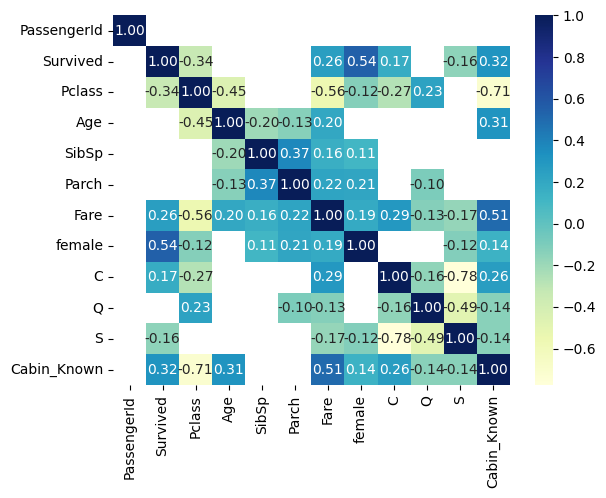

In [13]:
corr = data.corr()
sns.heatmap(corr,cmap='YlGnBu',annot=True, fmt= '.2f',mask=corr.apply(lambda x: x.abs() < 0.1))
plt.show()

There seems to be some correlation between having cabin data available and survival. Notably, gender, fare, embarked and class are all well correlated, too. Since Cabin data and Survival seem to be correlated, lets drill down further and isolate the cabin-letters, which indicate the deck the passenger's room was located in.

In [14]:
# CABIN:

# ---- Isolate the Deck & Check Results ---- #
data["Deck_Letter"] = data["Cabin"].apply(lambda x: x[0] if pd.notna(x) else 'NA')
# display(data["Deck_Letter"].value_counts())
# Result: Single "T" Cabin; Most Similar to A 
data.loc[data["Deck_Letter"]=='T', 'Deck_Letter'] = 'A'
# display(data["Deck_Letter"].value_counts())

# ---- 1-Hot Cabin Letters ---- #
OH_Deck = pd.get_dummies(data["Deck_Letter"], prefix = "Deck")
data.drop(["Deck_Letter","Cabin"], axis=1, inplace=True)
data = pd.concat([data, OH_Deck], axis=1)
display(data.head(5))

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,female,C,Q,S,Cabin_Known,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_NA
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,1,0,0,1,0,0,1,0,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,0,1,1,0,0,1,0,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,0,0,1,0,0,0,0,0,0,0,0,1


In [15]:
# # ---- Visualize Deck Survival ---- #
# fig, axs = plt.subplots(figsize=(10, 6))
# sns.countplot(x="Deck_Letter", hue='Survived', data=data)
# plt.xlabel('Deck Letter', size=12, labelpad=20)
# plt.ylabel('Passenger Count', size=12, labelpad=20)
# plt.show()
# ---- % survival per deck ---- #
survived_cnts = data[data['Survived'] == 1][['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_NA']].sum()
died_cnts = data[data['Survived'] == 0][['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_NA']].sum()

for deck in survived_cnts.index:
    print("{:.2f}% Survival on {}".format(survived_cnts.loc[deck]/(survived_cnts.loc[deck] + died_cnts.loc[deck])*100, deck))

43.75% Survival on Deck_A
74.47% Survival on Deck_B
59.32% Survival on Deck_C
75.76% Survival on Deck_D
75.00% Survival on Deck_E
61.54% Survival on Deck_F
50.00% Survival on Deck_G
29.99% Survival on Deck_NA


There seems to be some significant relationship between survivability and what deck a person's cabin was on. Unfortunately, I don't think there's a reasonable way to extrapolate the cabin-deck information of the null-valued passengers, unless this information is somehow encoded in the ticket, which I could not determine that it is.

For the `Ticket` feature, manual review (no statistics or visualizations) indicates that passengers who travelled together (i.e. shared a cabin #) appear to have the same value for their `Ticket`. This somewhat resolves the 'maid' issue that the competition posting indicates, and makes frequency-counting a fairly reliable way to get an accurate travel-group-size without the constraints of the `SibSp` and `Parch` features. That said, the family data isn't made entirely irrelevant -- not all family members share a cabin -- but it allows us to more reasonably condense and simplify our utilization of that information while retaining the more explicit group size as a reliable balance to the simplification we perform. 

In [16]:
ticket_frequency = data.Ticket.value_counts()
data["Group Size"] = data.Ticket.apply(lambda x: ticket_frequency[x])

# data[data["Name"].str.startswith("Braund")] # Example of Family that don't travel together. Likely brothers.

data["Family Cnt"] = data["Parch"] + data["SibSp"] + 1
# len(data[data["Family Cnt"] != data["Group Size"]]) # 284 records where family and group differ
# display(data["Family Cnt"].describe()) # mean is 1.9, std is 1.6
labels = [1,2,3,4] 
data["Fam Bin"] = pd.cut(data['Family Cnt'], labels = labels, bins = [0,2,5,7,12])
data.drop(["Ticket","Cabin_Known","Family Cnt", "Parch", "SibSp", "Name"], axis = 1, inplace=True)
# data[data["Family Cnt"] > 2].sample(10)

I could and arguably *should* try more feature engineering tricks. Feminine titles could indicate marital status, which may play a role in survivorship, titles given to dr/royalty/military/religion may indicate higher or  lower survival odds, etc. however, I do not intend to make this first project as robust as absolutely possible. There are other things I'd like to work on with more pressing timelines.

---

### Splitting our training data into training and testing, building and evaluating our model

A relatively straight forward use of a grid search over some semi-arbitrarily chosen values for 
the most signficant hyperparameters of a Random Forest Classifier. 

In [17]:
from sklearn.model_selection import GridSearchCV

# data.info() # Sanity Check: Only NaN's left are from the test set label column
train, test = data[~data["Survived"].isna()],data[data["Survived"].isna()]
X_train,Y_train = train.drop(["Survived","PassengerId"], axis = 1), train["Survived"]
# train.shape, test.shape

# X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_train,Y_train, test_size = .2, random_state=0)
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8]
}

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose = 2)
# grid_search.fit(X_train, Y_train)

# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)
# post_gs_model = model = RandomForestClassifier('max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100)


In [44]:
# Commented out after losing the grid_search variable and not wanting to rerun.
# Preferred method for using GS results.
# post_gs_model = grid_search.best_estimator_ x

post_gs_model = RandomForestClassifier(max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 100)
post_gs_model.fit(X_train, Y_train)

x_test = test.drop(['Survived','PassengerId'], axis = 1)
res = post_gs_model.predict(x_test)

res = pd.Series(res)
sub = pd.concat([test["PassengerId"], res], axis = 1)
sub.rename(columns = {0:'Survived'}, inplace=True)
sub["Survived"] = sub["Survived"].astype('uint')

sub.to_csv("my_first_submission.csv", index=False)